### Imports

In [5]:
import jax
import jax.numpy as jnp
from jax import random
import optax
from realnvp.bijections import RealNVP
import equinox as eqx
import matplotlib.pyplot as plt
from sklearn import datasets, preprocessing
from tqdm import tqdm

### Generate data

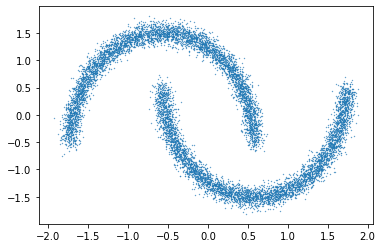

In [2]:
n_samples = 10000
plot_range = [(-2, 2), (-2, 2)]
n_bins = 100

scaler = preprocessing.StandardScaler()
x, _ = datasets.make_moons(n_samples=n_samples, noise=.05)
x = scaler.fit_transform(x)
x = jnp.array(x)
plt.scatter(x[:, 0], x[:, 1], s=0.1)

### Define loss and training loop

In [6]:

@eqx.filter_value_and_grad
def loss_value_and_grad(model, x):
    return -jax.vmap(model.log_prob)(x).mean()

@eqx.filter_jit
def step(model, x_batch, optimizer, opt_state):
    loss, grads = loss_value_and_grad(model, x_batch)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

    
def train(key, model, x, optimizer, epochs=10, batch_size=200):
    params, _ = eqx.partition(model, eqx.is_array)
    opt_state = optim.init(params)
    losses = []
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        key, subkey = random.split(key)
        x = random.permutation(key, x)
        for i in range(0, x.shape[0]-batch_size, batch_size):
            xi = x[i : i+batch_size]
            model, opt_state, loss = step(model, xi, optimizer, opt_state)
            losses.append(loss.item())
        pbar.set_postfix({"loss": loss.item()})
    return model, losses


### Train and plot samples

In [8]:
%%time
key = random.PRNGKey(0)
model = RealNVP(key, 2, 30, 2, 10)
optim = optax.adam(1e-3)

key, subkey = random.split(key)
model, losses = train(
    key, model, x, optim, epochs = 100, batch_size=400)

# Large batch size doesn't slow things down much. So slow bit is probably pure python loops or something?

100%|██████████| 100/100 [00:31<00:00,  3.16it/s, loss=-.393] 

CPU times: user 31.8 s, sys: 56 ms, total: 31.9 s
Wall time: 31.8 s


In [ ]:
# 31.8s

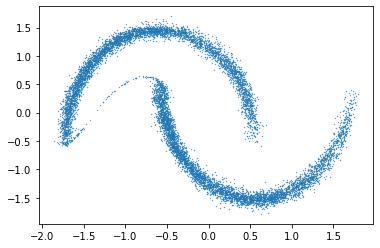

In [ ]:
key, subkey = random.split(key)
z = jax.random.normal(key, (10000, 2))
x_samples = jax.vmap(model.inverse)(z)
plt.scatter(x_samples[:, 0], x_samples[:, 1], s=0.1)
